# **Import library**

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
from sklearn.preprocessing import LabelEncoder

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Clean the data**

In [2]:
data = pd.read_csv("IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)  # Loại bỏ các ký tự không phải chữ cái
    text = text.lower()  # Chuyển đổi về chữ thường
    words = word_tokenize(text)  # Tách câu thành các từ
    words = [word for word in words if word not in stop_words]  # Loại bỏ từ dừng
    words = [stemmer.stem(word) for word in words]  # Stemming
    words = [lemmatizer.lemmatize(word) for word in words] #Lemmazation
    return ' '.join(words)  # Kết hợp các từ thành một chuỗi và trả về

In [4]:
data['review'] = data['review'].apply(preprocess_text)
data.head()

,review,sentiment
0,one review mention watch oz episod hook right ...,positive
1,wonder littl product br br film techniqu unass...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic famili littl boy jake think zombi closet...,negative
4,petter mattei love time money visual stun film...,positive


In [5]:
df = data.sample(frac=1, random_state=42).reset_index(drop=True) #Xáo hàng

# Tỉ lệ mẫu cho tập kiểm tra và tập validation
test_size = 0.2

# Tính số lượng mẫu cho tập kiểm tra và tập validation
num_test_samples = int(test_size * len(df))

# Tách DataFrame thành tập huấn luyện, tập kiểm tra và tập validation
train_df = df.iloc[num_test_samples:]
test_df = df.iloc[:num_test_samples]

# Tách các cột "review" và "sentiment" thành x_train, y_train, x_test, y_test, x_validation, y_validation
x_train, y_train = train_df['review'], train_df['sentiment']
x_test, y_test = test_df['review'], test_df['sentiment']


# **Navie Bayes - Text Classcification**

In [52]:
def train_naive_bayes(X_train, y_train, alpha=10.0):
    # Tính toán xác suất tiền điều kiện P(word|class) và xác suất hậu điều kiện P(class|word)
    class_word_counts = defaultdict(lambda: defaultdict(int))
    class_totals = defaultdict(int)
    vocabulary = set()

    for doc, label in zip(X_train, y_train):
        words = preprocess_text(doc)
        class_totals[label] += len(words)
        for word in words:
            class_word_counts[label][word] += 1
            vocabulary.add(word)

    return class_word_counts, class_totals, vocabulary


In [53]:
def predict_naive_bayes(X_test, class_word_counts, class_totals, vocabulary, alpha=10.0):
    predictions = []
    for doc in X_test:
        words = preprocess_text(doc)
        scores = {}

        for label, class_total in class_totals.items():
            log_prob = 0

            for word in words:
                # Laplace smoothing
                word_count = class_word_counts[label].get(word, 0) + alpha
                word_prob = word_count / (class_total + alpha * len(vocabulary))
                log_prob += np.log(word_prob)

            scores[label] = log_prob

        prediction = max(scores, key=scores.get)
        predictions.append(prediction)

    return predictions

In [54]:
class_word_counts, class_counts, vocabulary = train_naive_bayes(x_train, y_train)
y_pred = predict_naive_bayes(x_test, class_word_counts, class_counts, vocabulary)
correct_predictions = sum(1 for true, pred in zip(y_test, y_pred) if true == pred)
accuracy = correct_predictions / len(y_test)

print("Accuracy:", accuracy)

Accuracy: 0.6115


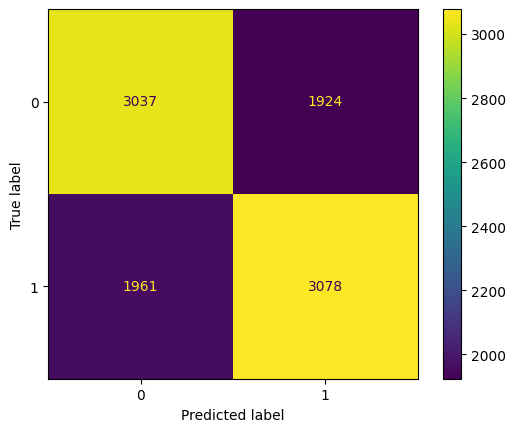

In [55]:
# Tạo một đối tượng LabelEncoder
label_encoder = LabelEncoder()

# Chuyển đổi nhãn thành số nguyên
y_test_int = label_encoder.fit_transform(y_test)
y_pred_int = label_encoder.transform(y_pred)

labels = [0, 1]

cm = confusion_matrix(y_test_int, y_pred_int, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

In [56]:
X_test_new = ["Idiot", "good film but idiot but i love this film", "bad action but good script i hate the actor so i love this film"]
y_pred_new = predict_naive_bayes(X_test_new, class_word_counts, class_counts, vocabulary)

for text, label in zip(X_test_new, y_pred_new):
    print(f"Text: {text} | Predicted Label: {label}")

Text: Idiot | Predicted Label: negative
Text: good film but idiot but i love this film | Predicted Label: positive
Text: bad action but good script i hate the actor so i love this film | Predicted Label: negative


In [60]:
sentences = []
text = input()
sentences.append(text)
pre_test = predict_naive_bayes(sentences, class_word_counts, class_counts, vocabulary)
print(f"Predicted Label: {pre_test}")

awful not good film
Predicted Label: ['negative']
